# Homework 2 

Pratham Mehta

## Question 1

In [2]:
## Part E


# Import
import numpy as np  
import pandas as pd 
from pathlib import Path  

 
# Load the weighted dolphin matrix
 
# file path 

file = "dolphin.csv"

# read file into pd df
W = pd.read_csv(file, header=None).values  

 
# Post-process to an unweighted simple graph
 
# Threshold: set 1 where weight >= 5, else 0

A = (W >= 5).astype(int)  # Create binary adjacency by thresholding at 5

# Zero out the diagonal to remove self-loops
np.fill_diagonal(A, 0)  # Ensure A_ii = 0

# For safety, symmetrize in case the CSV has small asymmetries (undirected expectation)
A = ((A + A.T) > 0).astype(int)  # Make adjacency symmetric: edge exists if either direction had 1

 
# (i) Degree of each node
 
# Degree vector k = A * 1, where 1 is the all-ones vector
k = A.sum(axis=1)  # Row sums of A give degrees in an undirected simple graph

 
# (ii) Number of edges
 
# m = (1/2) * 1^T * A * 1  == sum(k)/2
m = int(k.sum() // 2)  # Integer number of undirected edges

 
# (iii) Number of common neighbors for nodes 0 and 3
 
# Common neighbors matrix N = A^2; entry (i,j) counts common neighbors when i != j
A2 = A @ A  # Matrix square
common_0_3 = int(A2[0, 3])  # Common neighbors count between node 0 and node 3

 
# (iv) Total number of triangles
 
# Triangles T = trace(A^3)/6 in simple undirected graphs
A3 = A2 @ A  # Compute A^3
triangles = int(np.trace(A3) // 6)  # Each triangle contributes 6 to trace(A^3)

 
# print results
 
print("Q1(e) Results on Dolphin Network (threshold >= 5):")
print(f"(i) Degree of each node (k): {k.tolist()}")
print(f"(ii) Number of edges (m): {m}")
print(f"(iii) Common neighbors of nodes 0 and 3: {common_0_3}")
print(f"(iv) Total number of triangles: {triangles}")


Q1(e) Results on Dolphin Network (threshold >= 5):
(i) Degree of each node (k): [5, 5, 5, 4, 5, 2, 6, 2, 1, 1, 2, 2, 2]
(ii) Number of edges (m): 21
(iii) Common neighbors of nodes 0 and 3: 3
(iv) Total number of triangles: 18


## Question 2

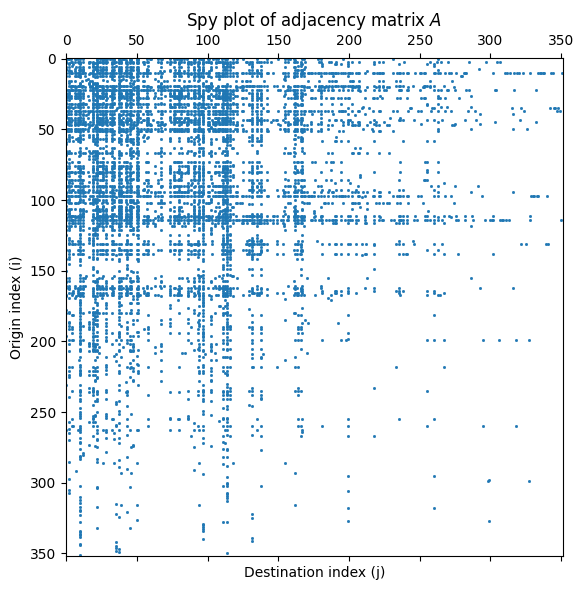

Q2(b) Directed diameter of LSCC (adjacency-power method): 6
Q2(c) Airports reachable from CHO in exactly 1 flight(s): 5
Q2(c) Airports reachable from CHO in exactly 2 flight(s): 193
Q2(c) Airports reachable from CHO in exactly 3 flight(s): 149
Q2(c) Airports reachable from CHO in exactly 4 flight(s): 3
Q2(d) Top-5 airports by total degree (in+out):
  1. DFW: 354
  2. DEN: 326
  3. ATL: 306
  4. ORD: 297
  5. CLT: 266


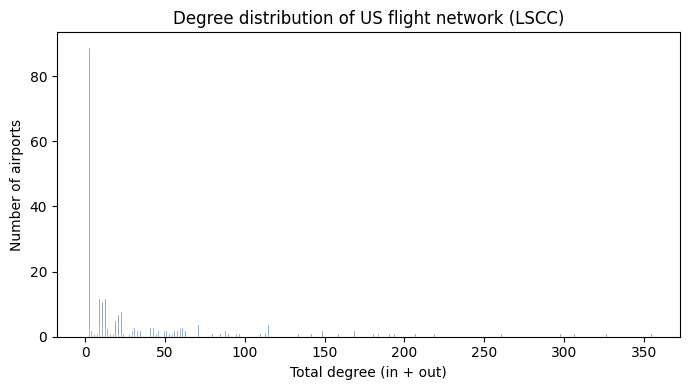

Q2(e) Interpretation: Right-skewed degree distribution reflects hub-and-spoke routing—
few hubs with large connectivity and many regional airports with smaller degree.


In [3]:


import polars as pl                  
import networkx as nx                
import numpy as np                   
import matplotlib.pyplot as plt     
from pathlib import Path             
from collections import defaultdict 


 
# Load and preprocess the data (given)
 
bts_path = "BTS2025.csv"

# read file into polars df
df = pl.read_csv(bts_path)  

# Filter out cargo/low-traffic flights: keep only rows with PASSENGERS > 1000
df = df.filter(pl.col("PASSENGERS") > 1000)

# Build a directed graph from (ORIGIN, DEST) pairs; rows() returns Python tuples
G = nx.DiGraph(df[["ORIGIN", "DEST"]].rows())

# Extract the largest strongly connected component (LSCC) to ensure finite directed distances
lscc = max(nx.strongly_connected_components(G), key=len)  # Find the largest SCC (set of nodes)
G = G.subgraph(lscc).copy()                                # Keep only the LSCC as a new DiGraph

 
# Build node-index maps and adjacency
 
# Map airport code -> matrix row/col index
nodedict = {node: i for i, node in enumerate(G.nodes)}

# Reverse map: index -> airport code
reverse_nodedict = {i: node for i, node in enumerate(G.nodes)}

# Build the adjacency matrix A in the consistent node order
A = nx.to_numpy_array(G, nodelist=nodedict.keys(), dtype=int)  # A[i,j] = 1 if edge i->j, else 0

 
# Q2(a): Spy plot of the adjacency matrix
 
plt.figure(figsize=(6, 6))                     # Create a square-ish figure
plt.spy(A, markersize=1)                        # Spy plot shows nonzeros; markersize controls dot size
plt.title("Spy plot of adjacency matrix $A$")   # Title for plot
plt.xlabel("Destination index (j)")             # Label x-axis
plt.ylabel("Origin index (i)")                  # Label y-axis
plt.tight_layout()                              # Improve spacing
plt.show()                                      # Display the figure

 
# Q2(b): Diameter using adjacency powers
 
# We find directed shortest-path distances by adjacency-matrix powers:
# distance(i,j) is the smallest ℓ >= 1 such that (A^ℓ)[i,j] > 0.
# Strategy:
# 1) Initialize a matrix 'reachable' as zeros.
# 2) Iteratively compute P = A, A^2, A^3, ..., updating distances where first seen.
# 3) Stop when all pairs are assigned or at ℓ up to N-1 (diameter upper bound in strongly connected digraph).

n = A.shape[0]                               # Number of nodes in the LSCC
dist = np.full((n, n), np.inf)               # Initialize distance matrix with infinity
np.fill_diagonal(dist, 0)                    # Zero distance to self
power = A.copy()                             # Start with A^1
reachable_any = (A > 0).astype(int)          # Track any reachability discovered so far

# For all (i,j) where A[i,j] > 0, set distance(i,j) = 1 initially
dist = np.where(A > 0, np.minimum(dist, 1), dist)

# Iteratively compute higher powers and update distances
for ell in range(2, n + 1):                  # ℓ from 2 up to n (safe bound)
    power = power @ A                         # Compute A^ell iteratively
    newly_reached = (power > 0) & (dist == np.inf)  # Pairs first reachable at this ℓ
    dist[newly_reached] = ell                 # Assign those distances
    if not newly_reached.any():               # If no new pairs, we can stop early
        break

# The diameter is the maximum finite entry in dist
diameter = int(np.nanmax(dist[np.isfinite(dist)]))  # Convert to int for printing

print(f"Q2(b) Directed diameter of LSCC (adjacency-power method): {diameter}")

 
# Q2(c): Reachability from CHO in 1,2,3,4 flights
 
# Find index of CHO; if CHO isn't in LSCC, this code will handle gracefully.
if "CHO" in nodedict:
    cho_idx = nodedict["CHO"]                   # Index for CHO
    # Keep track of nodes first reached at each flight length
    reached_by_len = {1: set(), 2: set(), 3: set(), 4: set()}
    # Compute successive powers of A applied to one-hot vector for CHO
    e = np.zeros((n, 1), dtype=int)             # Column vector of zeros
    e[cho_idx, 0] = 1                           # Make it the basis vector for CHO

    # Iterate flight lengths 1..4
    v = e.copy()                                 # v will hold A^ℓ * e
    for ell in range(1, 5):                      # For ℓ = 1,2,3,4
        v = A @ v                                # Multiply by A to advance one hop
        idxs = set(np.where(v.flatten() > 0)[0]) # Indices with positive reachable counts
        # Exclude CHO itself if it appears
        if cho_idx in idxs:
            idxs.remove(cho_idx)
        # Exclude nodes already reached at smaller ℓ (exactly-ℓ reachability)
        for smaller in range(1, ell):
            idxs -= reached_by_len[smaller]
        reached_by_len[ell] = idxs               # Store the exact-ℓ set

    # Print counts and (optionally) airport codes
    for ell in range(1, 5):
        codes = [reverse_nodedict[i] for i in sorted(reached_by_len[ell])]
        print(f"Q2(c) Airports reachable from CHO in exactly {ell} flight(s): {len(codes)}")
        # Uncomment next line if you want to see the actual airport codes
        # print(f"  Codes: {codes}")
else:
    print("Q2(c) CHO not in the LSCC after filtering; no reachability counts reported.")

 
# Q2(d): Top-5 airports by total degree (in + out)
 
# Out-degree from rows: k_out = A * 1
k_out = A.sum(axis=1)                           # Sum along rows
# In-degree from columns: k_in = A^T * 1
k_in = A.sum(axis=0)                            # Sum along columns
# Total degree
k_tot = k_out + k_in                            # Elementwise sum

# Build a list of (airport_code, total_degree) and sort descending by degree
pairs = [(reverse_nodedict[i], int(k_tot[i])) for i in range(n)]
pairs.sort(key=lambda x: x[1], reverse=True)

# Take top five
top5 = pairs[:5]
print("Q2(d) Top-5 airports by total degree (in+out):")
for rank, (code, deg) in enumerate(top5, start=1):
    print(f"  {rank}. {code}: {deg}")

 
# Q2(e): Histogram of degree distribution and interpretation
 
plt.figure(figsize=(7, 4))                      # Create figure for histogram
plt.hist(k_tot, bins=range(0, int(k_tot.max()) + 2, 1), color="#4C78A8", edgecolor="white")
plt.xlabel("Total degree (in + out)")           # X-axis label
plt.ylabel("Number of airports")                # Y-axis label
plt.title("Degree distribution of US flight network (LSCC)")  # Title
plt.tight_layout()                               # Adjust layout
plt.show()                                       # Display the histogram

print("Q2(e) Interpretation: Right-skewed degree distribution reflects hub-and-spoke routing—")
print("few hubs with large connectivity and many regional airports with smaller degree.")


Spy plot::

This spy plot shows which origin–destination pairs have direct flights. Each blue dot is a nonstop route, so rows with many dots are airports that fly to many destinations, and columns with many dots are airports receiving many flights. The dense regions near the top left show major hubs that connect heavily with each other, while most of the matrix is empty—indicating the network is sparse overall.